# Dive Prediction - Time Series Deep Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 600s
* *Output resolution*: 60s
* *Representation of trajectories* : Time Series
* *Layers* : deep convolutions




## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [4]:
data_train = pd.read_csv('./data/data_train.csv')
data_test = pd.read_csv('./data/data_test.csv')

In [5]:
def standardize(var):
    var = np.array(var)
    return (var-np.mean(var))/np.std(var)

def standardize_minmax(var):
    var = np.array(var)
    return (var-np.min(var))/(np.max(var) - np.min(var))

In [6]:
data_train = data_train.copy()
data_train = data_train.dropna()
data_train['lon_std'] = 0
data_train['lat_std'] = 0
data_train['step_speed_std'] = 0
data_train['step_direction_cos'] = 0
data_train['step_direction_sin'] = 0
    
for trip in data_train.trip.unique():
    data_train.loc[data_train.trip == trip,'lon_std'] = standardize(data_train.loc[data_train.trip == trip,'lon'])
    data_train.loc[data_train.trip == trip, 'lat_std'] = standardize(data_train.loc[data_train.trip == trip,'lat'])
    data_train.loc[data_train.trip == trip,'step_speed_std'] = standardize_minmax(data_train.loc[data_train.trip == trip,'step_speed'])
    data_train.loc[data_train.trip == trip,'step_direction_cos'] = np.cos(data_train.loc[data_train.trip == trip,'step_direction']* np.pi/180)
    data_train.loc[data_train.trip == trip,'step_direction_sin'] = np.sin(data_train.loc[data_train.trip == trip,'step_direction']* np.pi/180)

In [7]:
data_train.head()

,trip,datetime,lon,lat,pressure,gaps,step_speed,step_direction,dive,lon_std,lat_std,step_speed_std,step_direction_cos,step_direction_sin
2,P1108_46_SV_T1,2008-12-05 15:12:41,-77.262442,-11.773072,-0.26,False,7.224129,3.984122,0,1.452647,1.542331,0.246157,0.997583,0.069480
3,P1108_46_SV_T1,2008-12-05 15:12:42,-77.262447,-11.773147,-0.26,False,8.366185,13.285157,0,1.452565,1.541362,0.285681,0.973238,0.229798
4,P1108_46_SV_T1,2008-12-05 15:12:43,-77.262482,-11.773217,-0.22,False,8.675223,22.346828,0,1.451995,1.540458,0.296376,0.924899,0.380212
5,P1108_46_SV_T1,2008-12-05 15:12:44,-77.262517,-11.773293,-0.29,False,9.279737,-1.813227,0,1.451424,1.539476,0.317297,0.999499,-0.031641
6,P1108_46_SV_T1,2008-12-05 15:12:45,-77.262518,-11.773372,-0.19,False,8.794348,-23.557701,0,1.451408,1.538456,0.300499,0.916658,-0.399672


# Neural Network

In [13]:
# hyperparameters
batch_size = 16
learning_rate = 0.01
variable = ('lon_std', 'lat_std', 'step_speed_std', 'step_direction_cos', 'step_direction_sin')
window = 600
rescale = 10

train_set = TrajDataSet(data_train, window, variable, transform = transforms.Compose([Rescale(rescale), ToTensor()]))
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [14]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.cnn_input_1 = nn.Sequential(
            nn.Conv1d(5, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 1)
        )

        self.cnn_input_2 = nn.Sequential(
            nn.Conv1d(8, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 1)
        )

        self.cnn_input_3 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(32, 32, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_3 = nn.Sequential(
            nn.MaxPool1d(kernel_size = 11, stride = 2, padding = 5, dilation = 4)
        )

        self.cnn_4 = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(16, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            nn.Conv1d(8, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1)
        )

                
    def forward(self, x):
        out = x.squeeze(1)
        out = self.cnn_input_1(out)
        out = self.pooling_1(out)
        out = self.cnn_input_2(out)
        out = self.pooling_2(out)
        out = self.cnn_input_3(out)
        out = self.pooling_3(out)
        out = self.cnn_4(out)

        return out
    
def get_score(out, y):
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))
#     return (true_positive.detach().numpy().item() , true_negative.detach().numpy().item())

In [15]:
# get sample
x, y = next(iter(train_loader)) 

# Forward model
model = ConvNet()
out = model(x)

# Loss and score
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([15]))
criterion(out, y)
get_score(out, y)

(12.0, 85.0)

## Training

In [16]:
# # switch to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [17]:
list_loss = []
list_score = []
i = 0

for epoch in range(5):
    learning_rate /= 10
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for batch, (x, y) in enumerate(train_loader):
        i+=1

        # Train the model
        model.train()

    #     # send to GPU
    #     x, y = x.to(device), y.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:

            score = get_score(out,y)
            list_loss.append(loss.item())
            list_score.append(score)

            print('Epoch {}, Step {}, Loss: {}, True Positive : {}, True Negative : {} %'
                    .format(epoch, i + 1, loss.item(), score[0], score[1]))

Epoch 0, Step 100, Loss: 1.1119441986083984, True Positive : 88.0, True Negative : 51.0 %
Epoch 0, Step 200, Loss: 0.8343439102172852, True Positive : 91.0, True Negative : 56.0 %
Epoch 0, Step 300, Loss: 0.5825784206390381, True Positive : 100.0, True Negative : 69.0 %
Epoch 0, Step 400, Loss: 0.5136093497276306, True Positive : 81.0, True Negative : 79.0 %
Epoch 0, Step 500, Loss: 0.7820826172828674, True Positive : 88.0, True Negative : 69.0 %
Epoch 0, Step 600, Loss: 0.7521162033081055, True Positive : 95.0, True Negative : 67.0 %
Epoch 0, Step 700, Loss: 0.48694801330566406, True Positive : 97.0, True Negative : 75.0 %
Epoch 0, Step 800, Loss: 0.603681206703186, True Positive : 100.0, True Negative : 71.0 %
Epoch 0, Step 900, Loss: 0.5178752541542053, True Positive : 100.0, True Negative : 74.0 %
Epoch 0, Step 1000, Loss: 0.2758454978466034, True Positive : 79.0, True Negative : 90.0 %
Epoch 0, Step 1100, Loss: 0.8543655276298523, True Positive : 96.0, True Negative : 54.0 %
Epoch

KeyboardInterrupt: ignored

## Testing

In [18]:
data_test = data_test.copy()
data_test = data_test.dropna()
data_test['lon_std'] = 0
data_test['lat_std'] = 0
data_test['step_speed_std'] = 0
data_test['step_direction_cos'] = 0
data_test['step_direction_sin'] = 0
    
for trip in data_test.trip.unique():
    data_test.loc[data_test.trip == trip,'lon_std'] = standardize(data_test.loc[data_test.trip == trip,'lon'])
    data_test.loc[data_test.trip == trip, 'lat_std'] = standardize(data_test.loc[data_test.trip == trip,'lat'])
    data_test.loc[data_test.trip == trip,'step_speed_std'] = standardize_minmax(data_test.loc[data_test.trip == trip,'step_speed'])
    data_test.loc[data_test.trip == trip,'step_direction_cos'] = np.cos(data_test.loc[data_test.trip == trip,'step_direction']* np.pi/180)
    data_test.loc[data_test.trip == trip,'step_direction_sin'] = np.sin(data_test.loc[data_test.trip == trip,'step_direction']* np.pi/180)

In [19]:
dive_real = []
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Rescale(rescale), ToTensor()]))
    test_set_part = [test_set[i] for i in range(len(test_set)) if i%rescale == 0]
    
    # Test the model
    estim = np.zeros(int((len(t))/rescale))
    nb = np.zeros(int((len(t))/rescale))

    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y) in test_set_part:
            # Run the forward pass
            out = model(x.unsqueeze(0))
            
            estim[k:k + round(window/rescale)] += out.squeeze().numpy()
            nb[k:k + round(window/rescale)] += 1
            k+=1

    
    # remove extra lines
    t = t.drop(t.tail(len(t)%rescale ).index)
    real = np.array([np.max(t.dive[i:i+rescale]) for i in range(len(t)) if i%rescale == 0])
    
    # add to list by trajectory
    dive_real.append(real)
    dive_estim.append(estim/nb)
    
    
    print(i)

P1108_46_SV_T2
P1111_41_SV_T4
P1111_52_SV_T2
P1112_10_SV_T2
P1112_15_SV_T2
P1112_15_SV_T3
P1112_20_SV_T2
P1112_20_SV_T4
P1112_22_SV_T2
P1112_25_SV_T1
P1112_26_SV_T2
P1112_27_SV_T2
P1112_29_SV_T1
P1112_31_SV_T5
P1112_9_SV_T1
P1113_28_SV_T1
P1113_29_SV_T2
P1113_33_SV_T3
P1113_33_SV_T4


In [20]:
threshold = 0
dive_plot = np.array([1*(estim[i]>threshold)  for i in range(len(estim)) for k in range(rescale) ])

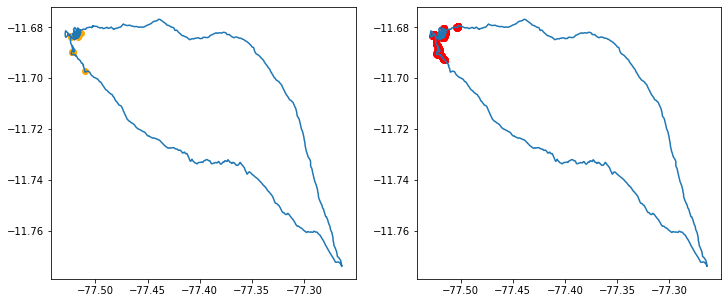

In [21]:
plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[dive_plot == 1], t.lat[dive_plot == 1], c = 'red')

# score

In [22]:
# globally
all_real = 1* (np.hstack(dive_real)> 0)
all_estim = 1* (np.hstack(dive_estim) > 0)

true_positive = np.mean(all_estim[all_real == 1])
true_negative = 1-np.mean(all_estim[all_real == 0])

true_positive, true_negative

(0.6778523489932886, 0.8402489626556017)

(0.7142857142857143, 0.9006211180124224)
(1.0, 0.8282442748091603)
(0.8, 0.9130434782608696)
(0.5, 0.9073482428115016)
(0.4473684210526316, 0.8297213622291022)
(0.7241379310344828, 0.7916666666666666)
(0.46153846153846156, 0.8997050147492626)
(0.4, 0.836)
(0.6666666666666666, 0.8375634517766497)
(1.0, 0.7664670658682635)
(0.75, 0.5900000000000001)
(0.75, 0.7046413502109705)
(1.0, 0.8347107438016529)
(0.8333333333333334, 0.7321428571428572)
(0.7241379310344828, 0.7888386123680241)
(0.8571428571428571, 0.8447653429602888)
(0.6923076923076923, 0.8923821039903265)
(0.6818181818181818, 0.647887323943662)
(0.6, 0.9202898550724637)


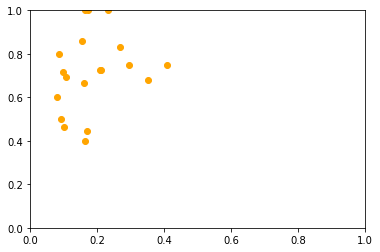

In [23]:
# for each trip
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for i in range(len(dive_real)):
    
    real = 1*(dive_real[i]>0)
    estim = 1*(dive_estim[i]>0)
    
    true_positive = np.mean(estim[real == 1])
    true_negative = 1-np.mean(estim[real == 0])

    ax.scatter(1-true_negative, true_positive, c = 'orange')
    
    print((true_positive, true_negative))

# ROC curve

In [26]:
# globally
TP = []
FP = []

all_real = 1* (np.hstack(dive_real)> 0)    
for tt in np.arange(-50, 50, 0.1):
    all_estim = 1* (np.hstack(dive_estim) > tt)
    true_positive = np.mean(all_estim[all_real == 1])
    true_negative = 1-np.mean(all_estim[all_real == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

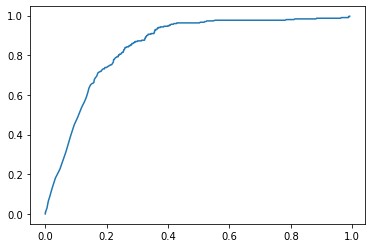

In [27]:
plt.plot(np.array(FP), np.array(TP))

In [28]:
data = {'model': 'network_timeseries',
        'FP':  FP,
        'TP': TP
        }

df = pd.DataFrame (data, columns = ['model','FP','TP'])

df.to_csv('roc_network_timeseries.csv', index = False)
# df.to_csv('./roc/roc_network_timeseries.csv', index = False)